# Leakage Prediction Using Recurrent Neural Networks (RNN)

## Task Overview
This project aims to develop a predictive model to classify leakage events in a system based on time-series sensor data. The primary objective is to implement a sliding window technique to preprocess the data and use Recurrent Neural Networks (RNN) to represent and predict leakage occurrences at the end of each window.

## Aim
The aim of this project is to accurately predict leakage events using historical sensor data by training an RNN model. The model will learn to generate embeddings for the sensor data within a specified window and utilize these embeddings for the classification task.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [71]:
# Read the data from an Excel file
file_path = './Resources/YVW-data-ready.xlsx'  # replace with your file path
sensor_data = pd.read_excel(file_path, engine='openpyxl')

# Print Sensor data
sensor_data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3,WMS0104.A3,WMS0116.A3,WBS628.A3,DMA_Formula,job_id,label
0,2023,4,0,0,0,92.332649,12.538504,10.382338,1.963230,10.9375,13.946571,8093218.0,1
1,2023,4,0,0,0,92.152722,12.120764,9.459019,1.590526,11.2500,11.920309,8093218.0,1
2,2023,4,0,0,0,91.792867,12.509483,10.789444,3.023685,11.1875,15.135112,8093218.0,1
3,2023,4,0,0,0,92.232689,13.223870,10.509808,2.733591,11.1250,15.342268,8093218.0,1
4,2023,4,1,0,0,92.432609,13.365288,11.280859,2.738526,11.7500,15.634672,8093218.0,1


In [72]:
# Function to create sliding windows
def create_sliding_window(df, window_size=20, step_size=1):
    X, y = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        X.append(window.drop(columns=['label', 'job_id']).values)
        y.append(window['label'].values[-1])
    return np.array(X), np.array(y)

# Prepare data using sliding window
features, target = create_sliding_window(df, window_size=20)

In [73]:
# Train-test split for Validation and Testing
X_train, X_tmp, y_train, y_tmp = train_test_split(features, target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# Check data split sizes
print("Shape of Training Set: ", X_train.shape)
print("Shape of Validation Set: ", X_val.shape)
print("Shape of Testing Set: ", X_test.shape)

Shape of Training Set:  (80777, 20, 11)
Shape of Validation Set:  (10097, 20, 11)
Shape of Testing Set:  (10098, 20, 11)


In [74]:
# Initialize a sequential model
model = Sequential()

# RNN layers
model.add(SimpleRNN(70, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(48, activation='relu'))

# Dense layer and Dropout Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

# Dense layer and Dropout Layer
model.add(Dense(36, activation='relu'))
model.add(Dropout(0.1))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Print model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_29 (SimpleRNN)   (None, 20, 70)            5740      
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 48)                5712      
                                                                 
 dense_37 (Dense)            (None, 64)                3136      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 36)                2340      
                                                                 
 dropout_26 (Dropout)        (None, 36)                0         
                                                                 
 dense_39 (Dense)            (None, 1)               

In [75]:
# Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, restore_best_weights=True)

In [76]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=120, 
                    validation_data=(X_val, y_val))

Epoch 1/120
2525/2525 [==============================] - 14s 5ms/step - loss: 16.9238 - accuracy: 0.5018 - val_loss: 0.8081 - val_accuracy: 0.5293
Epoch 2/120
2525/2525 [==============================] - 12s 5ms/step - loss: 3.5077 - accuracy: 0.5013 - val_loss: 0.7998 - val_accuracy: 0.4980
Epoch 3/120
2525/2525 [==============================] - 12s 5ms/step - loss: 1.7578 - accuracy: 0.5012 - val_loss: 0.7111 - val_accuracy: 0.4852
Epoch 4/120
2525/2525 [==============================] - 12s 5ms/step - loss: 1.0856 - accuracy: 0.5032 - val_loss: 0.7089 - val_accuracy: 0.4966
Epoch 5/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.8411 - accuracy: 0.5094 - val_loss: 0.6958 - val_accuracy: 0.5055
Epoch 6/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.7550 - accuracy: 0.5087 - val_loss: 0.6926 - val_accuracy: 0.5114
Epoch 7/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.7231 - accuracy: 0.5117 - val_loss: 0.6906 

Epoch 57/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5495 - accuracy: 0.7009 - val_loss: 0.5345 - val_accuracy: 0.7200
Epoch 58/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5494 - accuracy: 0.7002 - val_loss: 0.5577 - val_accuracy: 0.6961
Epoch 59/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5487 - accuracy: 0.7003 - val_loss: 0.5285 - val_accuracy: 0.7137
Epoch 60/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5485 - accuracy: 0.6997 - val_loss: 0.5291 - val_accuracy: 0.7198
Epoch 61/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5473 - accuracy: 0.7010 - val_loss: 0.5563 - val_accuracy: 0.6865
Epoch 62/120
2525/2525 [==============================] - 13s 5ms/step - loss: 0.5447 - accuracy: 0.7026 - val_loss: 0.5244 - val_accuracy: 0.7180
Epoch 63/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5448 - accuracy: 0.7032 - val_loss: 0

2525/2525 [==============================] - 12s 5ms/step - loss: 0.5023 - accuracy: 0.7340 - val_loss: 0.4844 - val_accuracy: 0.7510
Epoch 113/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.5004 - accuracy: 0.7350 - val_loss: 0.4861 - val_accuracy: 0.7341
Epoch 114/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.4985 - accuracy: 0.7370 - val_loss: 0.4916 - val_accuracy: 0.7446
Epoch 115/120
2525/2525 [==============================] - 13s 5ms/step - loss: 0.4984 - accuracy: 0.7376 - val_loss: 0.4814 - val_accuracy: 0.7333
Epoch 116/120
2525/2525 [==============================] - 13s 5ms/step - loss: 0.4971 - accuracy: 0.7377 - val_loss: 0.4981 - val_accuracy: 0.7374
Epoch 117/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.4948 - accuracy: 0.7398 - val_loss: 0.4724 - val_accuracy: 0.7527
Epoch 118/120
2525/2525 [==============================] - 12s 5ms/step - loss: 0.4966 - accuracy: 0.7384 - val_loss: 0.5103 -

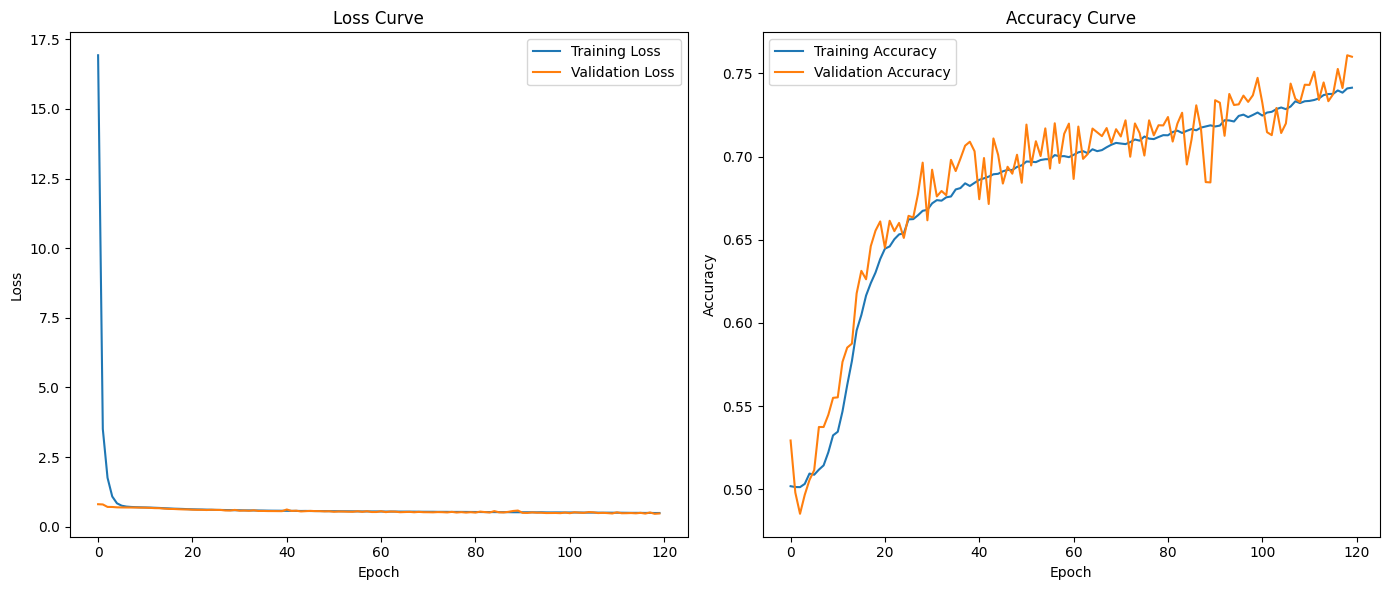

In [77]:
# Extract loss and accuracy values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss
ax1.plot(loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.plot(accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display plots
plt.tight_layout()
plt.show()

In [78]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

316/316 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7612
Test Loss: 0.47305047512054443
Test Accuracy: 0.7612398266792297
